In [1]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, T5Config, T5ForConditionalGeneration
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
import nltk

/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-02 18:05:36.729994: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-02 18:05:36.788085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-02 18:05:39.331180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not

In [5]:
path = '/home/hkqiu/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100'
tokenizer = AutoTokenizer.from_pretrained(path, bos_token='<s>', eos_token='</s>', pad_token='[PAD]', padding_side='right') 
configuration = T5Config.from_pretrained(path, output_hidden_states=False)
model = T5ForConditionalGeneration.from_pretrained(path, config=configuration)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
model.eval()

prompt = 'Predict the Tg of the following SMILES: CCCCCCCC=O'
target = '405'

inputs = tokenizer.encode_plus(prompt, max_length=10, truncation=True, padding="max_length", return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

print(f"input_ids:{input_ids}")

# 准备解码器的输入
decoder_input_ids = tokenizer.encode_plus(target, max_length=6, truncation=True, padding="max_length", return_tensors="pt")["input_ids"]

# 运行模型
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask,
     decoder_input_ids=decoder_input_ids, output_attentions=True)

outputs.keys()


input_ids:tensor([[32110,     3,  2823,  2823,  2823,  2823,  2423,   667,     1, 32101]])


odict_keys(['logits', 'past_key_values', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])

In [6]:
outputs.encoder_attentions[0].shape

torch.Size([1, 12, 10, 10])

/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: G

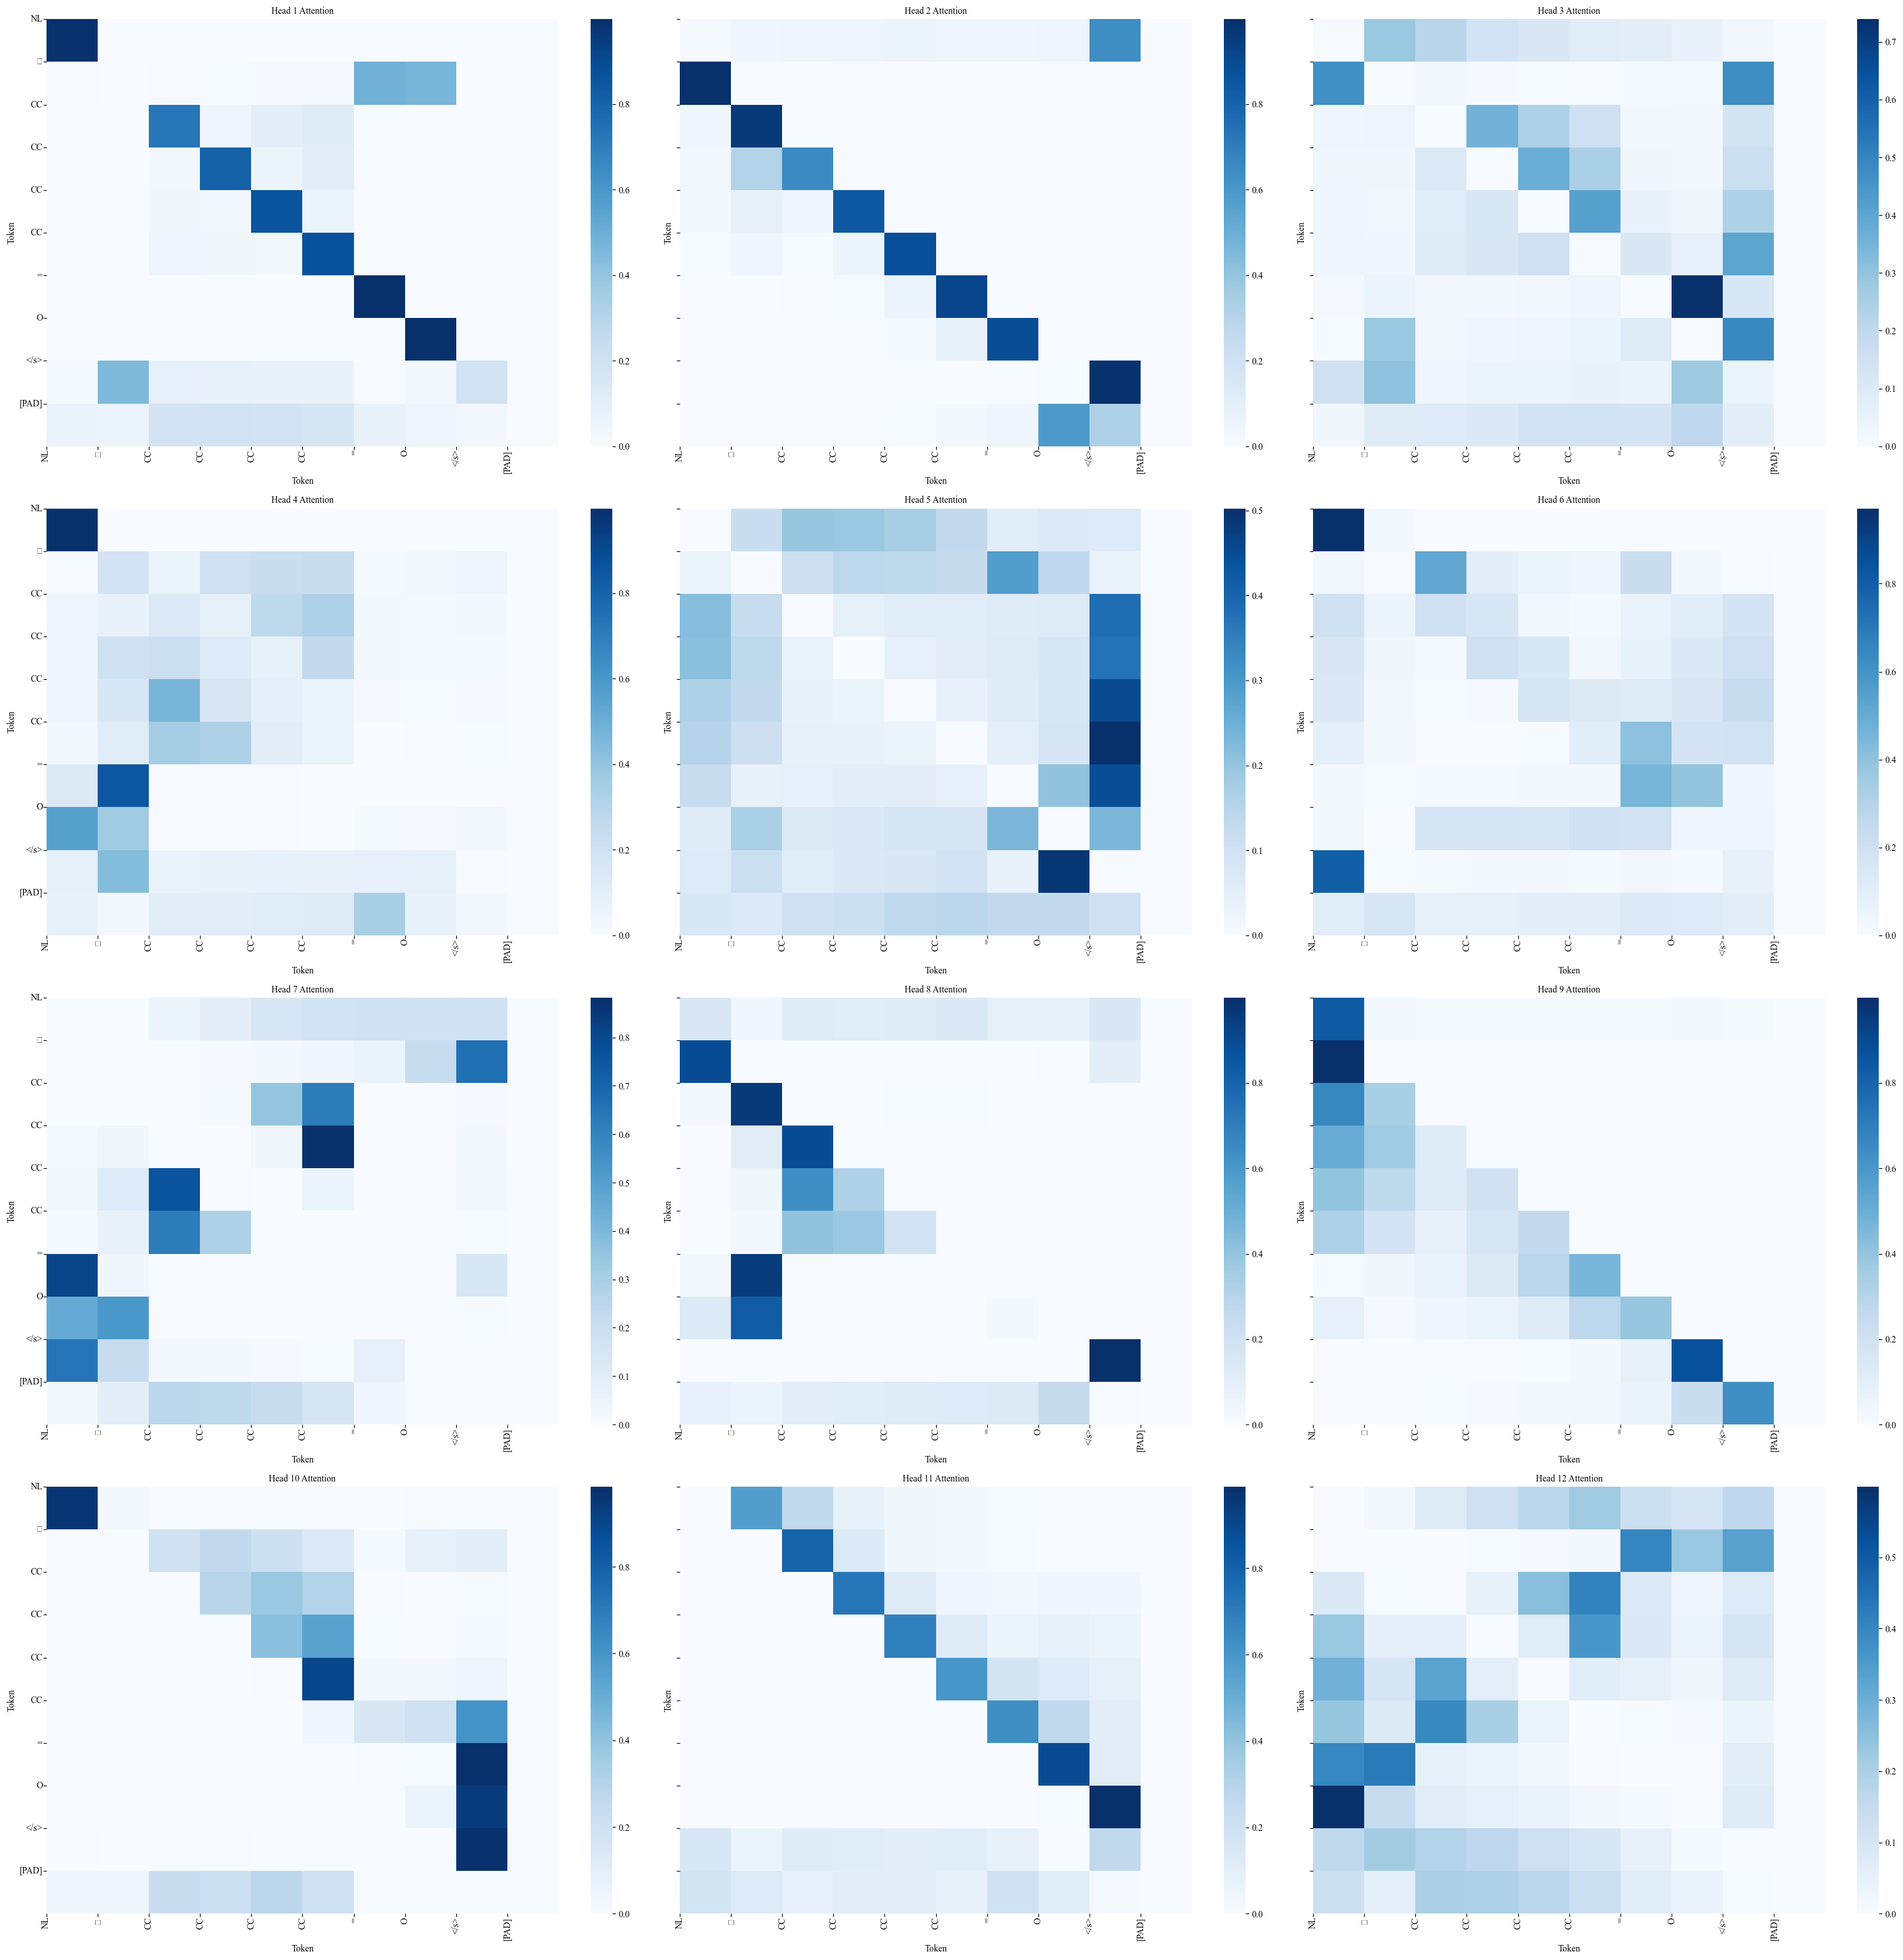

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager

# 设置字体
font_path = '/usr/share/fonts/Times/TIMES.TTF'  # 字体文件路径
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'Times New Roman'

# 获取注意力矩阵的值
attention_scores = outputs.encoder_attentions[0].squeeze().numpy()

# 获取标记文本
token_texts = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

token_texts[0] = 'NL'
# 遍历每个头并绘制热图
num_heads = attention_scores.shape[0]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 30), sharey=True)

for head in range(num_heads):
    # 获取当前头的注意力分数
    head_attention = attention_scores[head]

    # 计算当前头所在的行和列索引
    row = head // 3
    col = head % 3

    # 绘制热图
    sns.heatmap(head_attention, cmap="Blues", annot=False, ax=axs[row, col])
    axs[row, col].set_xlabel("Token", fontproperties=prop)
    axs[row, col].set_ylabel("Token", fontproperties=prop)
    axs[row, col].set_xticks(ticks=range(len(token_texts)))
    axs[row, col].set_xticklabels(token_texts, rotation=90, ha="center", fontproperties=prop)
    axs[row, col].set_yticks(ticks=range(len(token_texts)))
    axs[row, col].set_yticklabels(token_texts, rotation=0, va="center", fontproperties=prop)
    axs[row, col].set_title(f"Head {head+1} Attention", fontproperties=prop)
    axs[row, col].tick_params(axis="both", pad=0.5)

# 移除多余的子图
if num_heads < 12:
    for i in range(num_heads, 12):
        axs.flatten()[i].axis("off")

plt.tight_layout()
# plt.savefig('./attn-1.png',dpi=1000)
plt.show()

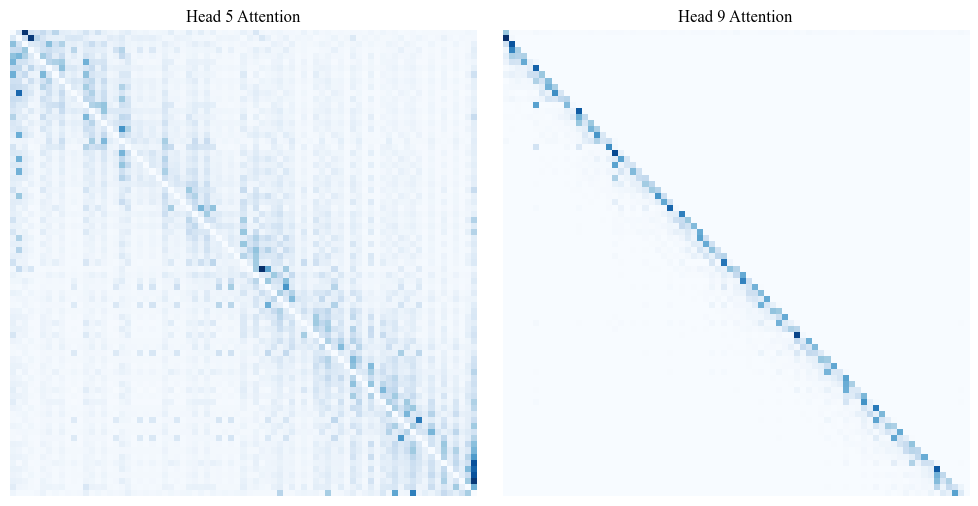

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取注意力矩阵的值
attention_scores = outputs.encoder_attentions[0].squeeze().numpy()

# 创建2x2的图
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


# 绘制第5个头的热图
axs[0].imshow(attention_scores[4], cmap="Blues")
axs[0].set_title("Head 5 Attention")
axs[0].axis("off")

# 绘制第9个头的热图
axs[1].imshow(attention_scores[8], cmap="Blues")
axs[1].set_title("Head 9 Attention")
axs[1].axis("off")

plt.tight_layout()
# plt.savefig('./attn-5-9-1.png',dpi=1000)
plt.show()

In [31]:
path = '/home/hkqiu/work/PolyGPT/T5/model_save/cls-T5-bs150-bs8-lr5e6-epoch100'
tokenizer = AutoTokenizer.from_pretrained(path, bos_token='<s>', eos_token='</s>', pad_token='[PAD]', padding_side='right') 
configuration = T5Config.from_pretrained(path, output_hidden_states=False)
model = T5ForConditionalGeneration.from_pretrained(path, config=configuration)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
model.eval()

prompt = 'Predict the Tg of the following SMILES: [*]C1=CC=C(C2=CC=C(C3=CC=C(N4C(C(C=CC(C5=CC=CC(C(C6[*])=O)=C5C6=O)=C7)=C7C4=O)=O)C=C3)C=C2)C=C1'
target = '390'

inputs = tokenizer.encode_plus(prompt, max_length=88, truncation=True, padding="max_length", return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

print(f"input_ids:{input_ids}")

# 准备解码器的输入
decoder_input_ids = tokenizer.encode_plus(target, max_length=6, truncation=True, padding="max_length", return_tensors="pt")["input_ids"]

# 运行模型
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask,
     decoder_input_ids=decoder_input_ids, output_attentions=True)


input_ids:tensor([[32110,   784,  1935,   908,   254,   536,  2423,  2823,  2423,   254,
           599,   254,   357,  2423,  2823,  2423,   254,   599,   254,   519,
          2423,  2823,  2423,   254,   599,   567,   591,   254,   599,   254,
           599,   254,  2423,  2823,   599,   254,   755,  2423,  2823,  2423,
          2823,   599,   254,   599,   254,   948,  6306,  1935,   908,    61,
          2423,   667,    61,  2423,   254,   755,   254,   948,  2423,   667,
            61,  2423,   254, 12703,  2423,   254,   940,   254,   591,  2423,
           667,    61,  2423,   667,    61,   254,  2423,   254,  5268,   254,
          2423,   254,  7318,   254,  2423,   254,   536,     1]])


In [32]:
token_texts = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
token_texts

['Predict the Tg of the following SMILES:',
 '▁[',
 '*',
 ']',
 'C',
 '1',
 '=',
 'CC',
 '=',
 'C',
 '(',
 'C',
 '2',
 '=',
 'CC',
 '=',
 'C',
 '(',
 'C',
 '3',
 '=',
 'CC',
 '=',
 'C',
 '(',
 'N',
 '4',
 'C',
 '(',
 'C',
 '(',
 'C',
 '=',
 'CC',
 '(',
 'C',
 '5',
 '=',
 'CC',
 '=',
 'CC',
 '(',
 'C',
 '(',
 'C',
 '6',
 '[',
 '*',
 ']',
 ')',
 '=',
 'O',
 ')',
 '=',
 'C',
 '5',
 'C',
 '6',
 '=',
 'O',
 ')',
 '=',
 'C',
 '7)',
 '=',
 'C',
 '7',
 'C',
 '4',
 '=',
 'O',
 ')',
 '=',
 'O',
 ')',
 'C',
 '=',
 'C',
 '3)',
 'C',
 '=',
 'C',
 '2)',
 'C',
 '=',
 'C',
 '1',
 '</s>']

/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/home/hkqiu/anaconda3/envs/work/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: G

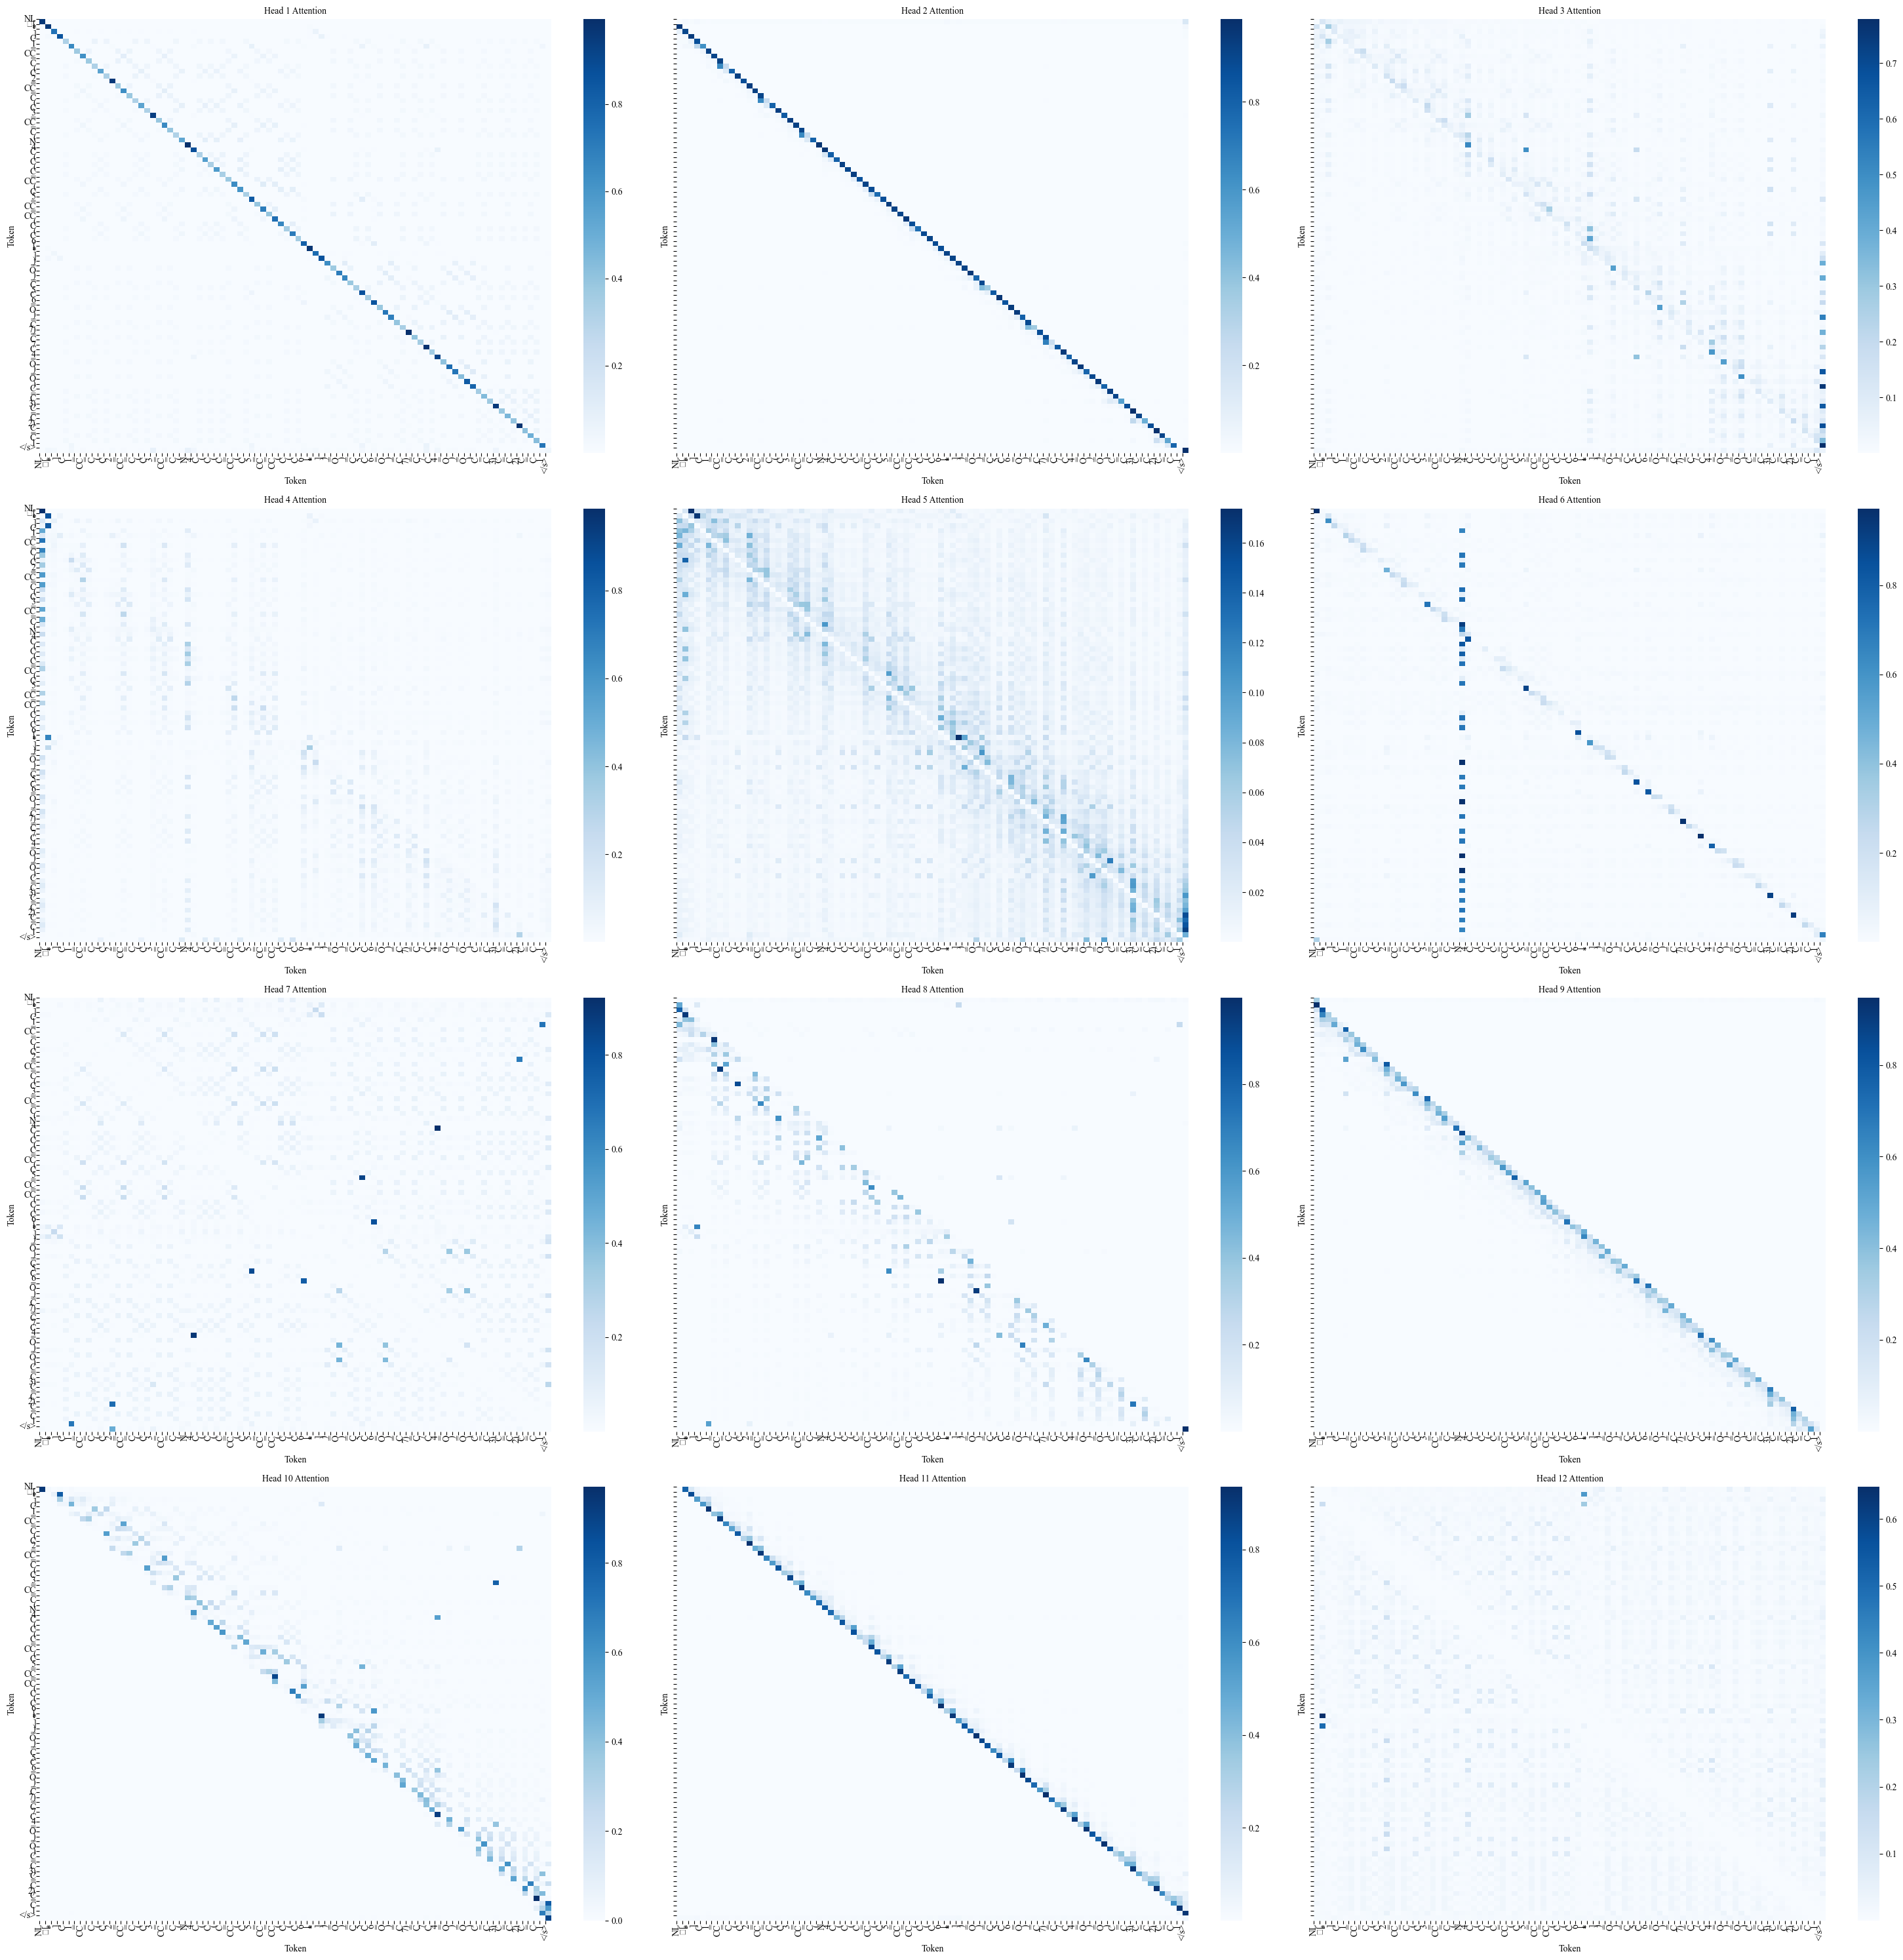

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager

# 设置字体
font_path = '/usr/share/fonts/Times/TIMES.TTF'  # 字体文件路径
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'Times New Roman'

# 获取注意力矩阵的值
attention_scores = outputs.encoder_attentions[0].squeeze().numpy()

# 获取标记文本
token_texts = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

token_texts[0] = 'NL'
# 遍历每个头并绘制热图
num_heads = attention_scores.shape[0]
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(30, 30), sharey=True)

for head in range(num_heads):
    # 获取当前头的注意力分数
    head_attention = attention_scores[head]

    # 计算当前头所在的行和列索引
    row = head // 3
    col = head % 3

    # 绘制热图
    sns.heatmap(head_attention, cmap="Blues", annot=False, ax=axs[row, col])
    axs[row, col].set_xlabel("Token", fontproperties=prop)
    axs[row, col].set_ylabel("Token", fontproperties=prop)
    axs[row, col].set_xticks(ticks=range(len(token_texts)))
    axs[row, col].set_xticklabels(token_texts, rotation=90, ha="center", fontproperties=prop)
    axs[row, col].set_yticks(ticks=range(len(token_texts)))
    axs[row, col].set_yticklabels(token_texts, rotation=0, va="center", fontproperties=prop)
    axs[row, col].set_title(f"Head {head+1} Attention", fontproperties=prop)
    axs[row, col].tick_params(axis="both", pad=0.5)

# 移除多余的子图
if num_heads < 12:
    for i in range(num_heads, 12):
        axs.flatten()[i].axis("off")

plt.tight_layout()
plt.savefig('./attn-2.png',dpi=1000)
plt.show()

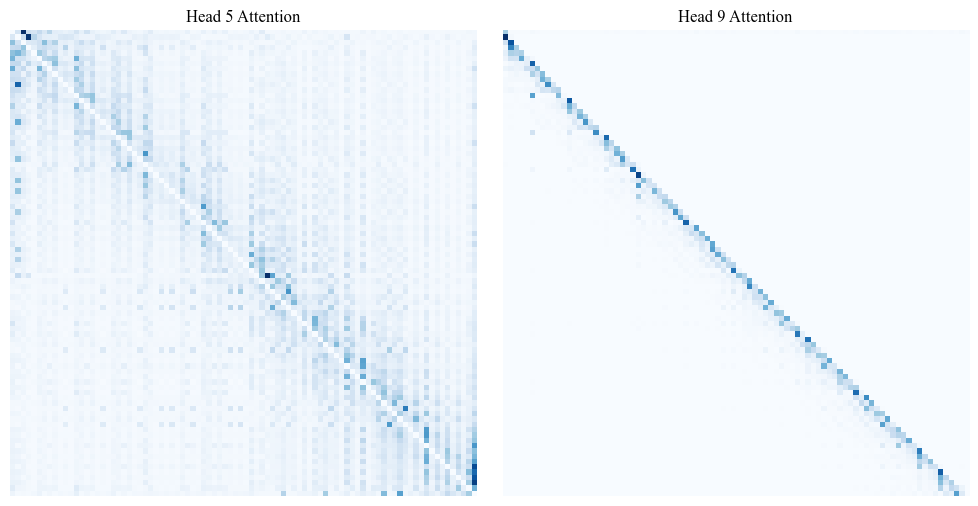

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取注意力矩阵的值
attention_scores = outputs.encoder_attentions[0].squeeze().numpy()

# 创建2x2的图
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


# 绘制第5个头的热图
axs[0].imshow(attention_scores[4], cmap="Blues")
axs[0].set_title("Head 5 Attention")
axs[0].axis("off")

# 绘制第9个头的热图
axs[1].imshow(attention_scores[8], cmap="Blues")
axs[1].set_title("Head 9 Attention")
axs[1].axis("off")

plt.tight_layout()
plt.savefig('./attn-5-9-2.png',dpi=1000)
plt.show()